### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install optuna

In [3]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [4]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
##%%time
dataset = pd.read_csv('Data/cleaned_data.csv')

In [5]:
dataset.head()

created_date  city_tier first_platform_c first_utm_medium_c  \
0  2021-07-01 00:08:15        1.0           Level0            Level11   
1  2021-07-01 00:16:43        2.0           Level3             Level0   
2  2021-07-01 00:22:20        1.0           Level3             Level0   
3  2021-07-01 00:23:13        1.0           Level1             Level3   
4  2021-07-01 00:28:38        1.0           Level3             Level0   

  first_utm_source_c  total_leads_droppped  referred_lead  app_complete_flag  \
0             Level2                   1.0            0.0                  1   
1             others                   1.0            0.0                  1   
2             Level0                   1.0            0.0                  1   
3             others                   2.0            0.0                  0   
4             Level0                   1.0            0.0                  0   

   assistance_interaction  career_interaction  payment_interaction  \
0                     0.0                 0.0                  0.0   
1                     0.0                 0.0                  0.0   
2                     0.0                 0.0                  0.0   
3                     0.0                 0.0                  0.0   
4                     0.0                 0.0                  0.0   

   social_interaction  syllabus_interaction  
0                 0.0                   0.0  
1                 0.0                   0.0  
2                 0.0                   0.0  
3                 0.0                   0.0  
4                 0.0                   0.0

In [6]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [8]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [9]:
mlflow.set_experiment('Lead_scoring_mlflow_experimentation')

2023/01/17 12:51:54 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_mlflow_experimentation' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/Assignment/mlruns/4', experiment_id='4', lifecycle_stage='active', name='Lead_scoring_mlflow_experimentation', tags={}>

In [10]:
dataset['city_tier'] = dataset.city_tier.astype('category')

In [11]:
ONE_HOT_ENCODED_FEATURES = ['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0', 'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3', 'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0', 'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15', 'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26', 'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4', 'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8', 'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14', 'first_utm_source_c_Level16', 'first_utm_source_c_Level2',
       'first_utm_source_c_Level4', 'first_utm_source_c_Level5', 'first_utm_source_c_Level6', 'first_utm_source_c_Level7',
       'first_utm_source_c_others', 'total_leads_droppped', 'referred_lead', 
       'assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction',
       'syllabus_interaction', 'app_complete_flag']

In [12]:
FEATURES_TO_ENCODE = ['city_tier', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']

In [13]:
encoded_df = pd.DataFrame(columns= ONE_HOT_ENCODED_FEATURES) # from constants.py
placeholder_df = pd.DataFrame()

In [14]:
# One-Hot Encoding using get_dummies for the specified categorical features
for f in FEATURES_TO_ENCODE:
    if(f in dataset.columns):
        encoded = pd.get_dummies(dataset[f])
        encoded = encoded.add_prefix(f + '_')
        placeholder_df = pd.concat([placeholder_df, encoded], axis=1)
    else:
        print('Feature not found')

In [15]:
# Implement these steps to prevent dimension mismatch during inference
for feature in encoded_df.columns:
    if feature in dataset.columns:
        encoded_df[feature] = dataset[feature]
    if feature in placeholder_df.columns:
        encoded_df[feature] = placeholder_df[feature]
# fill all null values
encoded_df.fillna(0, inplace=True)

In [16]:
# setup pycaret 
exp_lead_scoring = setup(data=encoded_df, target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   n_jobs=-1,use_gpu=False,
                       log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

### 4 : Model Experimentation with pycaret

In [17]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [18]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm')

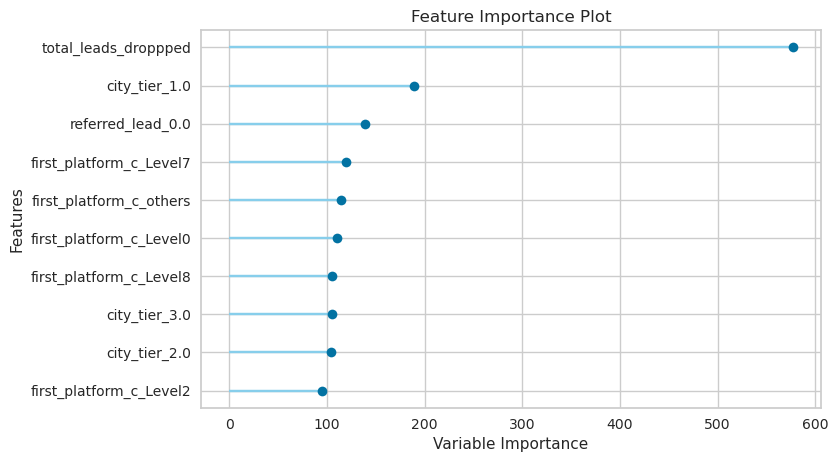

In [19]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the insignificant features is 
'assistance_interaction', 'career_interaction', 'payment_interaction',
       'social_interaction', 'syllabus_interaction'.
So now you will train your model without these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [23]:
#dropping 'assistance_interaction', 'career_interaction', 'payment_interaction','social_interaction', 'syllabus_interaction'

dataset_cols =  encoded_df.drop(['assistance_interaction', 'career_interaction', 'payment_interaction',
       'social_interaction', 'syllabus_interaction'],axis=1)

In [24]:
encoded_df.columns

Index(['city_tier_1.0', 'city_tier_2.0', 'city_tier_3.0',
       'first_platform_c_Level0', 'first_platform_c_Level1',
       'first_platform_c_Level2', 'first_platform_c_Level3',
       'first_platform_c_Level7', 'first_platform_c_Level8',
       'first_platform_c_others', 'first_utm_medium_c_Level0',
       'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11',
       'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15',
       'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2',
       'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26',
       'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30',
       'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4',
       'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5',
       'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8',
       'first_utm_medium_c_Level9', 'first_utm_medium_c_others',
       'first_utm_source_c_Level0', 'first_utm_source_c_Level14',
       'first_utm_source_c_Level16'

In [27]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 

from pycaret.classification import *

exp_lead_scoring = setup(data=dataset_cols, target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_mlflow_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [28]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm_fs = create_model('lightgbm')

In [29]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [30]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
